In [54]:
import pandas as pd
import numpy as np
import glob
import os
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

# Data Preperation

In [35]:
sensor_df = pd.read_csv('sensor_usage.csv')
energy_df = pd.read_csv('energy_usage.csv')
weather_df = pd.read_csv('sheffield 2023-11-01 to 2023-11-29.csv')
sensor_df['datetime'] = pd.to_datetime(sensor_df['datetime'])
energy_df['datetime'] = pd.to_datetime(energy_df['datetime'])
weather_df['datetime'] = pd.to_datetime(weather_df['datetime'])



In [37]:
#Filtering weather data
columns_to_drop = ['name','preciptype','severerisk','stations','visibility',
                   'solarenergy','solarradiation','windgust','winddir','precipprob',
                   'uvindex','snowdepth','snow','conditions', 'icon']
weather_df = weather_df.drop(columns=columns_to_drop)
weather_df.set_index('datetime', inplace=True)
weather_df = weather_df.resample('30T').interpolate()
weather_df.reset_index(inplace=True)
weather_df

,datetime,temp,feelslike,dew,humidity,precip,windspeed,sealevelpressure,cloudcover
0,2023-11-01 00:00:00,7.80,5.90,7.70,99.110,0.2350,11.00,997.40,87.6
1,2023-11-01 00:30:00,7.90,5.95,7.75,99.110,0.3815,11.15,996.80,93.8
2,2023-11-01 01:00:00,8.00,6.00,7.80,99.110,0.5280,11.30,996.20,100.0
3,2023-11-01 01:30:00,8.15,5.80,7.95,99.075,0.6145,13.85,995.45,100.0
4,2023-11-01 02:00:00,8.30,5.60,8.10,99.040,0.7010,16.40,994.70,100.0
...,...,...,...,...,...,...,...,...,...
1386,2023-11-29 21:00:00,-1.90,-4.60,-3.20,90.380,0.0000,7.20,1004.20,68.4
1387,2023-11-29 21:30:00,-1.85,-4.55,-3.30,89.740,0.0000,7.10,1004.15,53.1
1388,2023-11-29 22:00:00,-1.80,-4.50,-3.40,89.100,0.0000,7.00,1004.10,37.8
1389,2023-11-29 22:30:00,-1.65,-4.85,-3.10,90.105,0.0000,8.65,1004.15,33.8


In [38]:
#combining all data
df = pd.merge(energy_df, weather_df, on='datetime', how='left')
df = pd.merge(df, sensor_df, on='datetime', how='left')
df = df.dropna()
df

,datetime,Consumption (kWh),temp,feelslike,dew,humidity,precip,windspeed,sealevelpressure,cloudcover,sensor_temp
86,2023-11-02 19:00:00,0.92,8.50,5.30,8.10,97.650,1.2880,21.50,970.20,100.0,20.913295
87,2023-11-02 19:30:00,3.14,8.45,5.10,7.90,96.495,0.8695,22.90,970.65,100.0,20.971098
88,2023-11-02 20:00:00,0.96,8.40,4.90,7.70,95.340,0.4510,24.30,971.10,100.0,21.028902
89,2023-11-02 20:30:00,0.92,8.35,4.85,7.55,94.745,0.3125,24.85,971.50,100.0,21.052023
90,2023-11-02 21:00:00,0.88,8.30,4.80,7.40,94.150,0.1740,25.40,971.90,100.0,21.075145
...,...,...,...,...,...,...,...,...,...,...,...
1386,2023-11-29 21:00:00,0.88,-1.90,-4.60,-3.20,90.380,0.0000,7.20,1004.20,68.4,25.606936
1387,2023-11-29 21:30:00,0.84,-1.85,-4.55,-3.30,89.740,0.0000,7.10,1004.15,53.1,25.583815
1388,2023-11-29 22:00:00,0.05,-1.80,-4.50,-3.40,89.100,0.0000,7.00,1004.10,37.8,25.560694
1389,2023-11-29 22:30:00,0.18,-1.65,-4.85,-3.10,90.105,0.0000,8.65,1004.15,33.8,25.606936


# Data Preproccessing

In [39]:
def is_midnight(row):
    return 0 <= row.hour < 5

df['hour'] = df['datetime'].dt.hour
df['day_of_week'] = df['datetime'].dt.dayofweek
df['is_weekend'] = df['day_of_week'].isin([4, 5, 6]).astype(int)

df['midnight_flag'] = df['datetime'].apply(is_midnight)

bins = [0, 6, 9, 12, 15, 18, 21, 24]
labels = ['early_morning', 'morning', 'late_morning', 'early_afternoon', 'late_afternoon', 'evening', 'night']
df['part_of_day'] = pd.cut(df['hour'], bins=bins, labels=labels, right=False, include_lowest=True)
df

,datetime,Consumption (kWh),temp,feelslike,dew,humidity,precip,windspeed,sealevelpressure,cloudcover,sensor_temp,hour,day_of_week,is_weekend,midnight_flag,part_of_day
86,2023-11-02 19:00:00,0.92,8.50,5.30,8.10,97.650,1.2880,21.50,970.20,100.0,20.913295,19,3,0,False,evening
87,2023-11-02 19:30:00,3.14,8.45,5.10,7.90,96.495,0.8695,22.90,970.65,100.0,20.971098,19,3,0,False,evening
88,2023-11-02 20:00:00,0.96,8.40,4.90,7.70,95.340,0.4510,24.30,971.10,100.0,21.028902,20,3,0,False,evening
89,2023-11-02 20:30:00,0.92,8.35,4.85,7.55,94.745,0.3125,24.85,971.50,100.0,21.052023,20,3,0,False,evening
90,2023-11-02 21:00:00,0.88,8.30,4.80,7.40,94.150,0.1740,25.40,971.90,100.0,21.075145,21,3,0,False,night
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1386,2023-11-29 21:00:00,0.88,-1.90,-4.60,-3.20,90.380,0.0000,7.20,1004.20,68.4,25.606936,21,2,0,False,night
1387,2023-11-29 21:30:00,0.84,-1.85,-4.55,-3.30,89.740,0.0000,7.10,1004.15,53.1,25.583815,21,2,0,False,night
1388,2023-11-29 22:00:00,0.05,-1.80,-4.50,-3.40,89.100,0.0000,7.00,1004.10,37.8,25.560694,22,2,0,False,night
1389,2023-11-29 22:30:00,0.18,-1.65,-4.85,-3.10,90.105,0.0000,8.65,1004.15,33.8,25.606936,22,2,0,False,night


In [44]:
df.to_csv('dataframe.csv', index=False)

# Data Visulisation

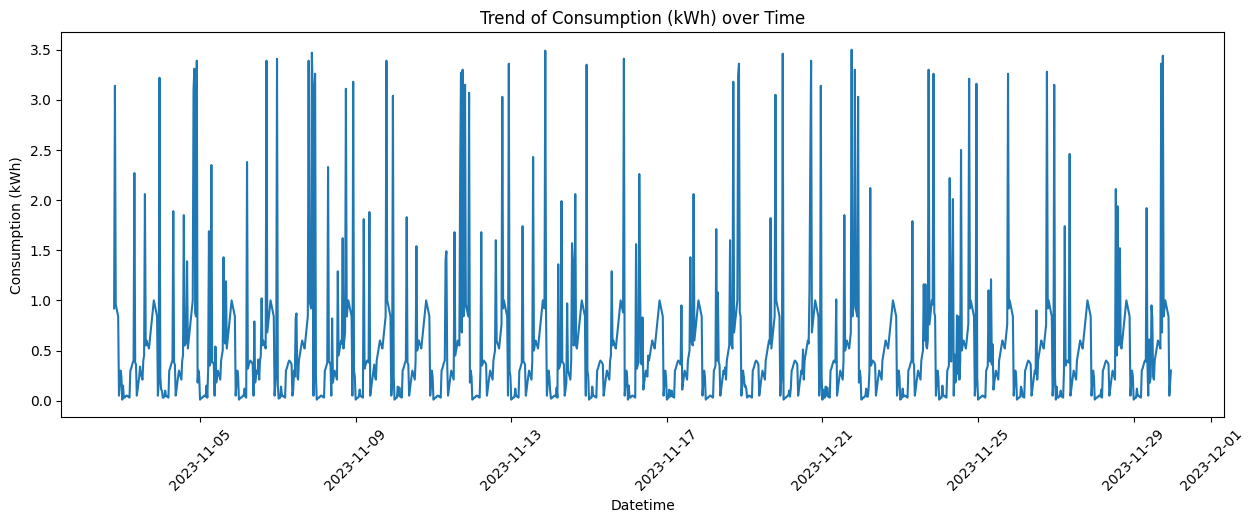

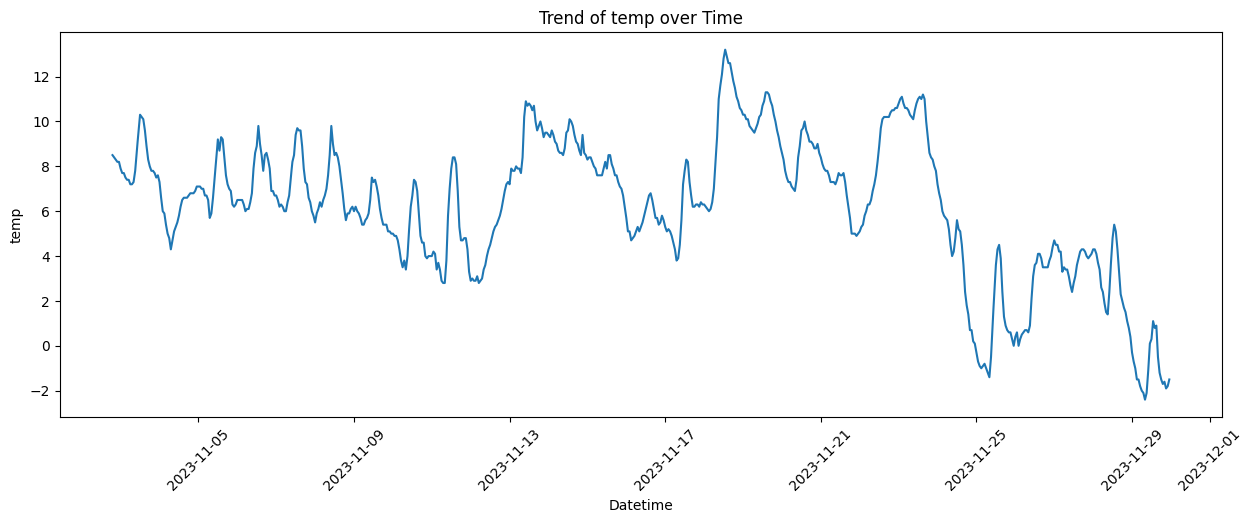

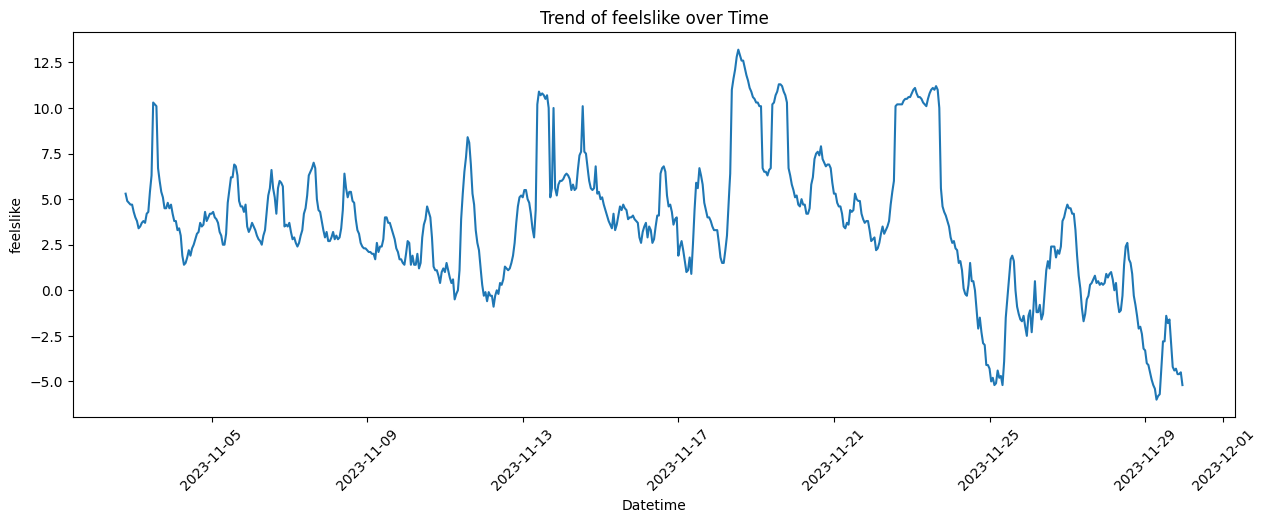

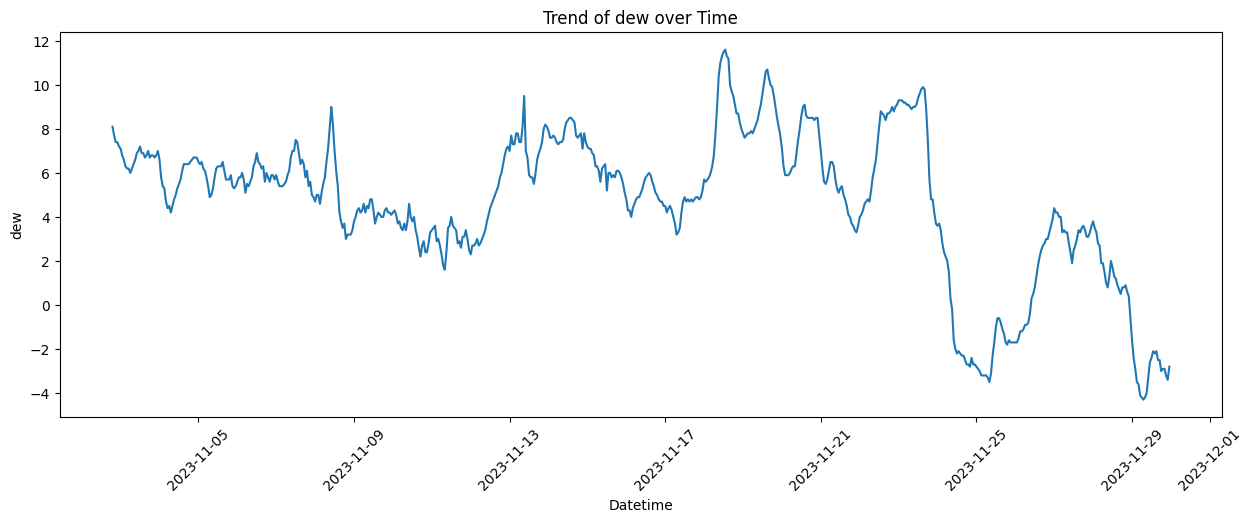

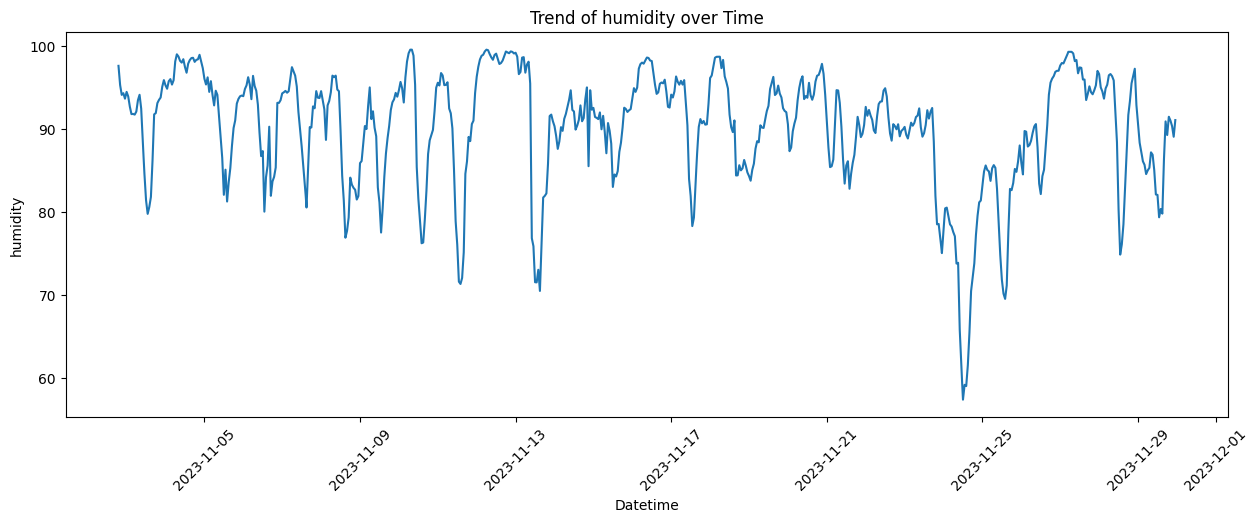

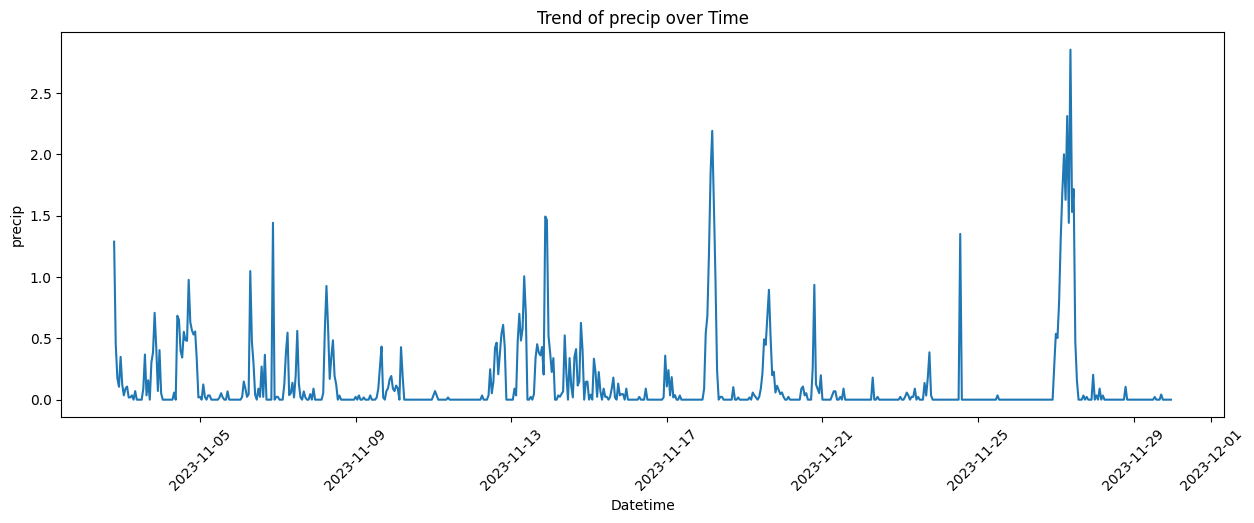

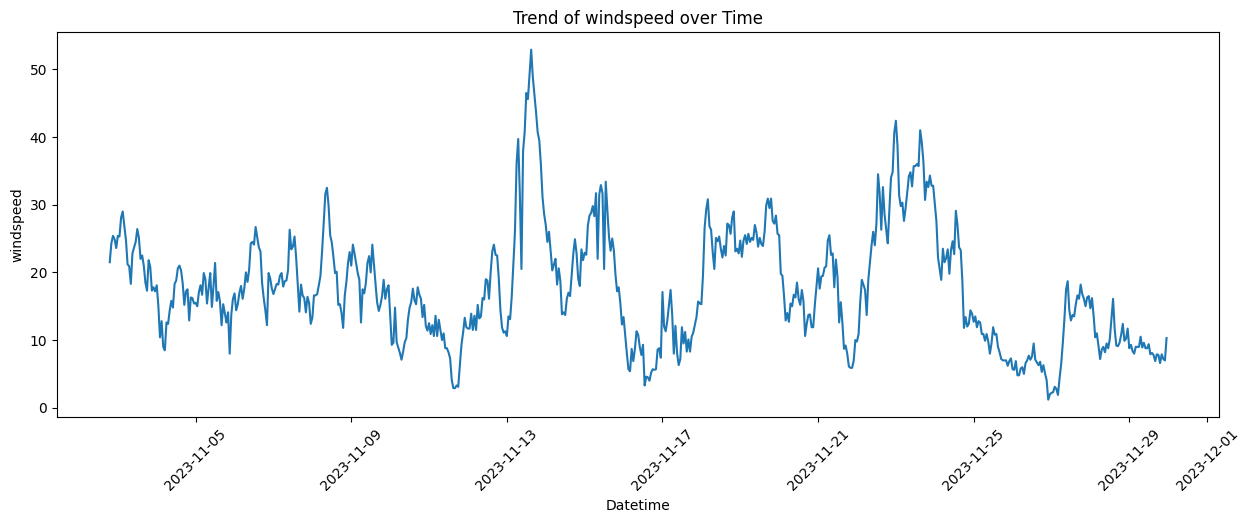

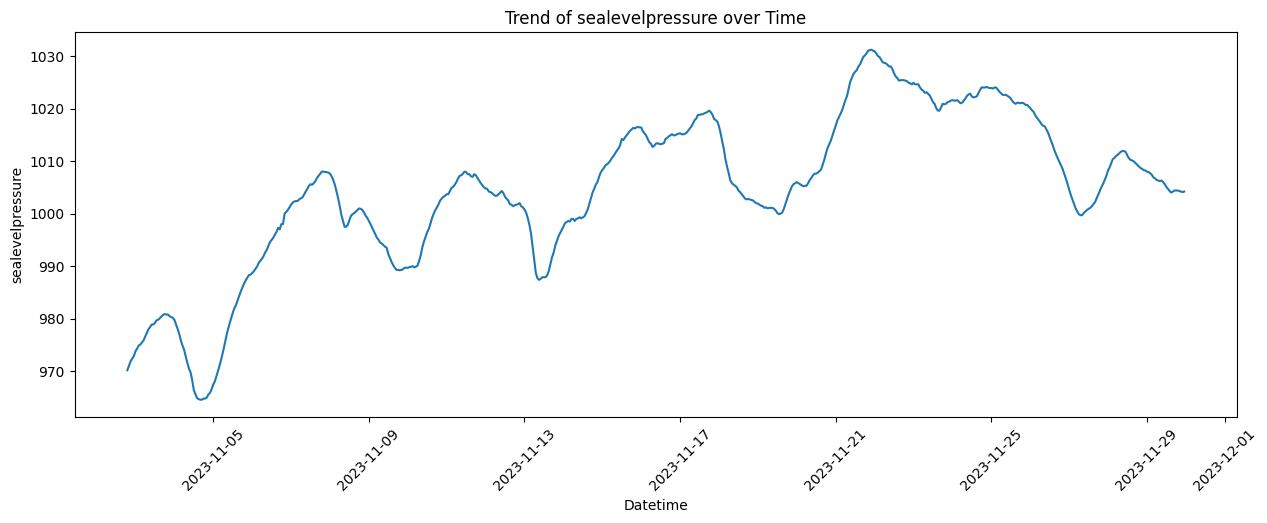

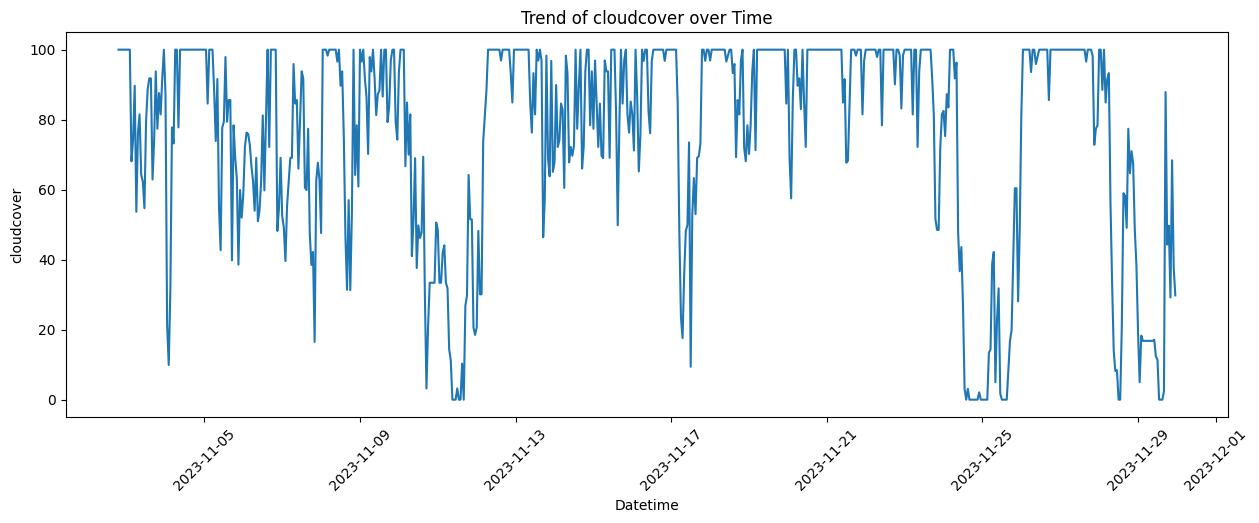

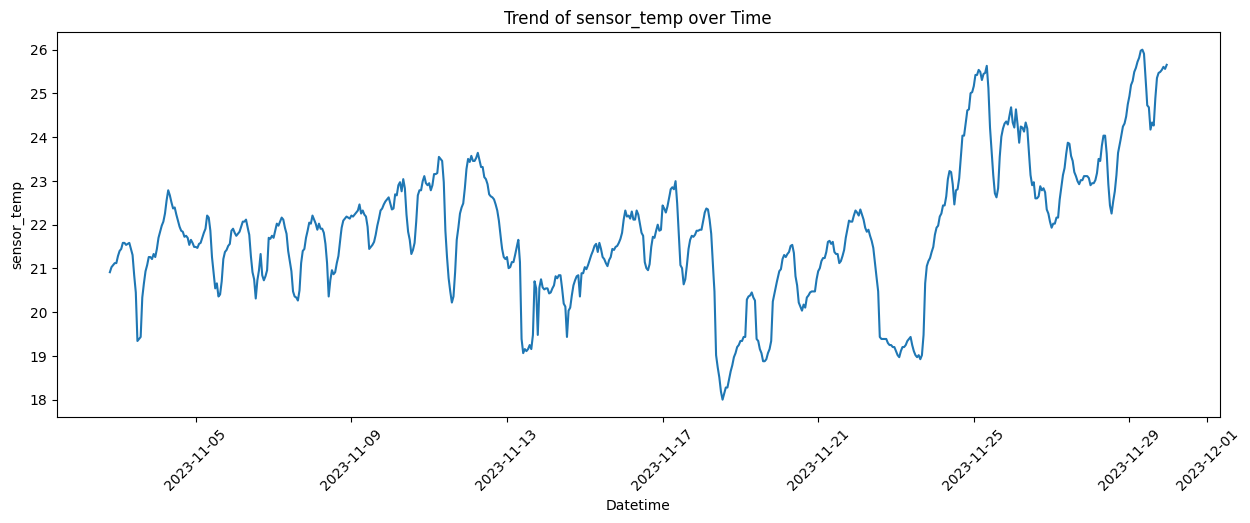

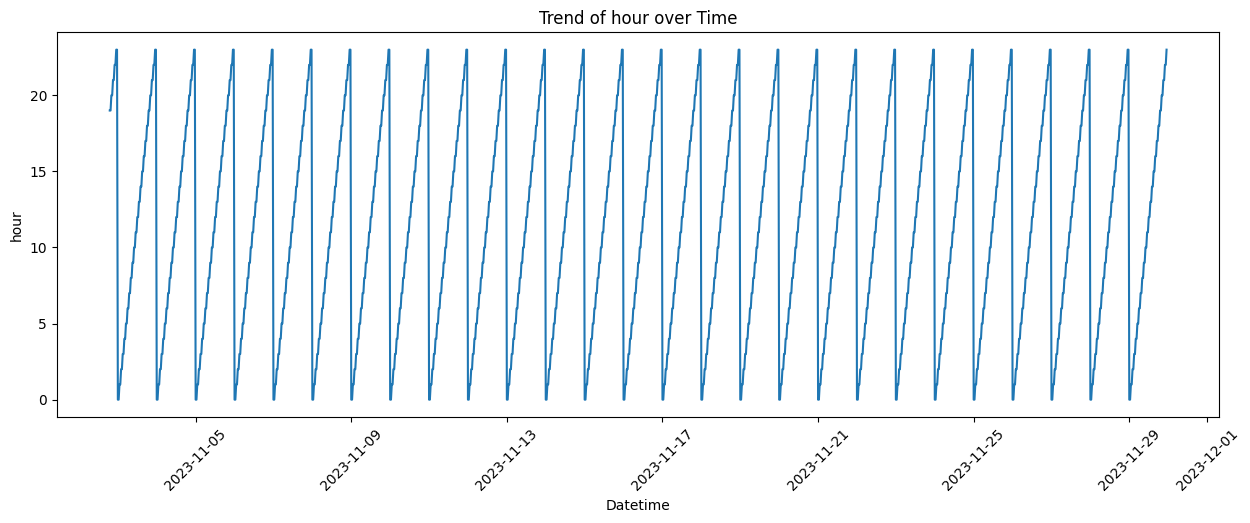

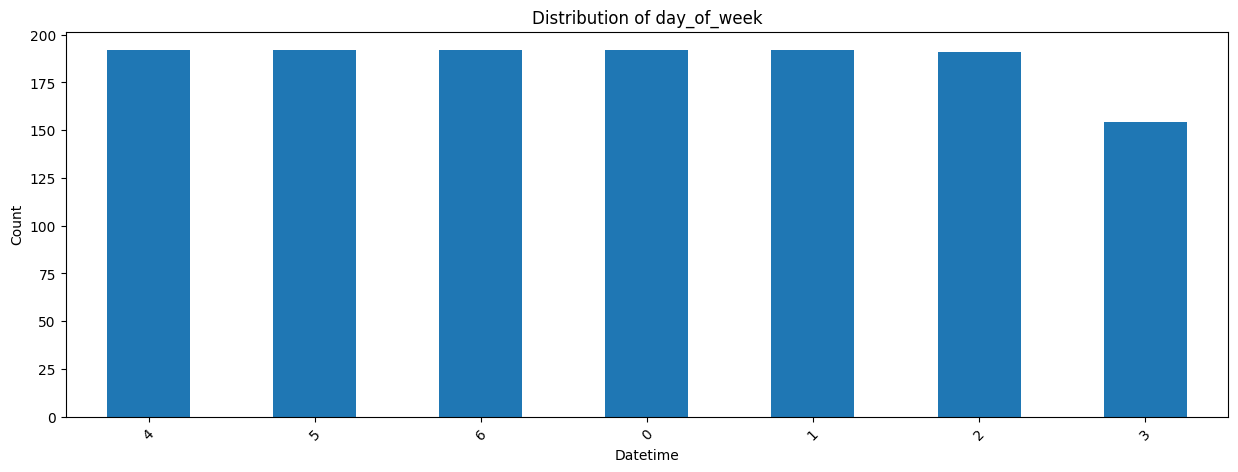

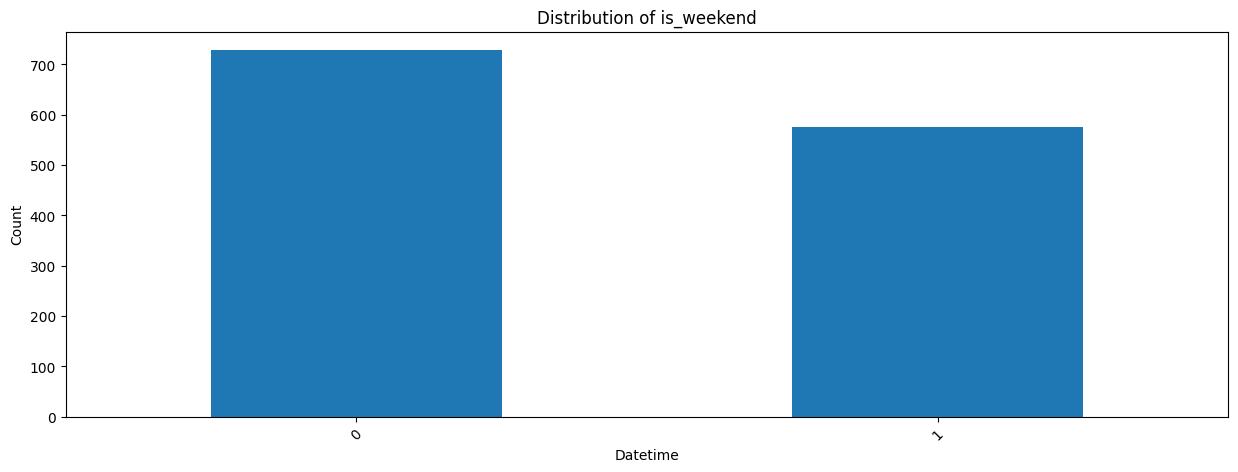

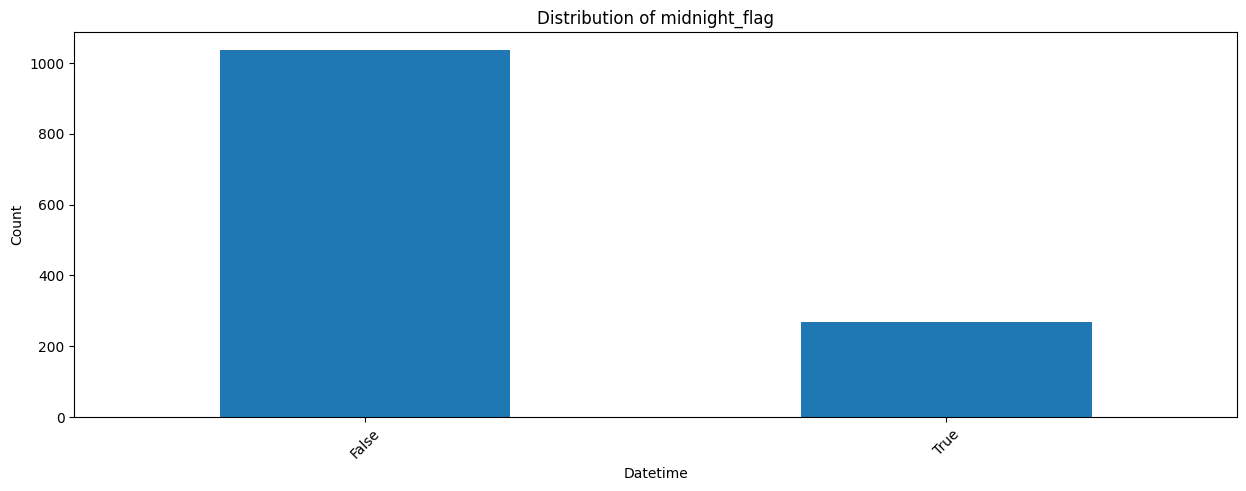

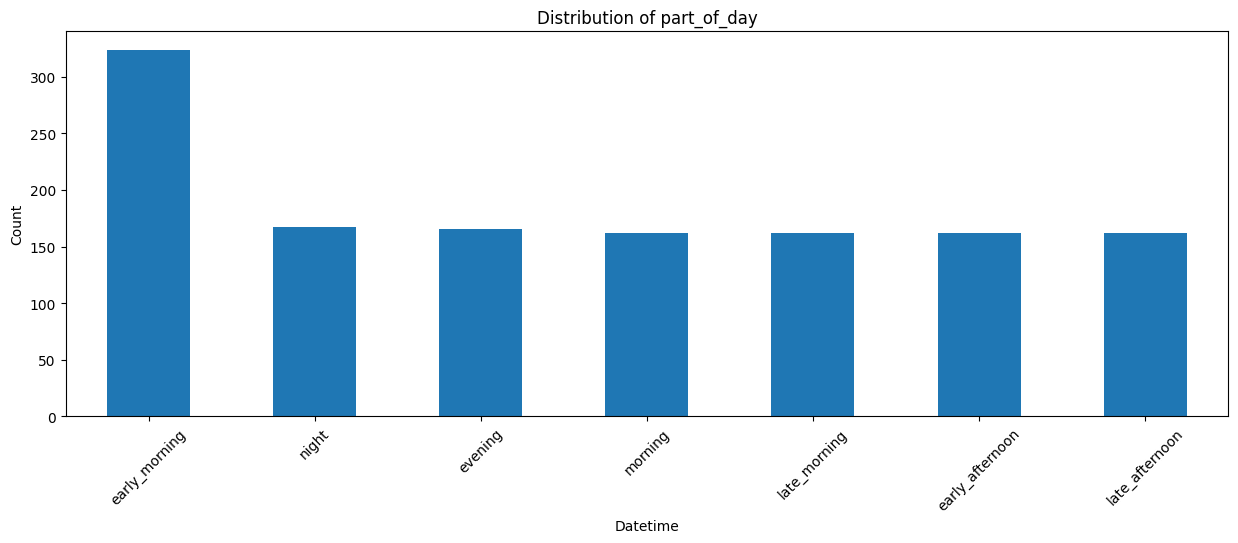

In [43]:
#Data distribution
for column in df.columns:
    if column != 'datetime':
        plt.figure(figsize=(15, 5))

        if column in ['midnight_flag','is_weekend' ,'part_of_day','day_of_week']:
            df[column].value_counts().plot(kind='bar')
            plt.title(f'Distribution of {column}')
            plt.ylabel('Count')
        else:
            plt.plot(df['datetime'], df[column])
            plt.title(f'Trend of {column} over Time')
            plt.ylabel(column)
        
        plt.xlabel('Datetime')
        plt.xticks(rotation=45) 
        plt.show()

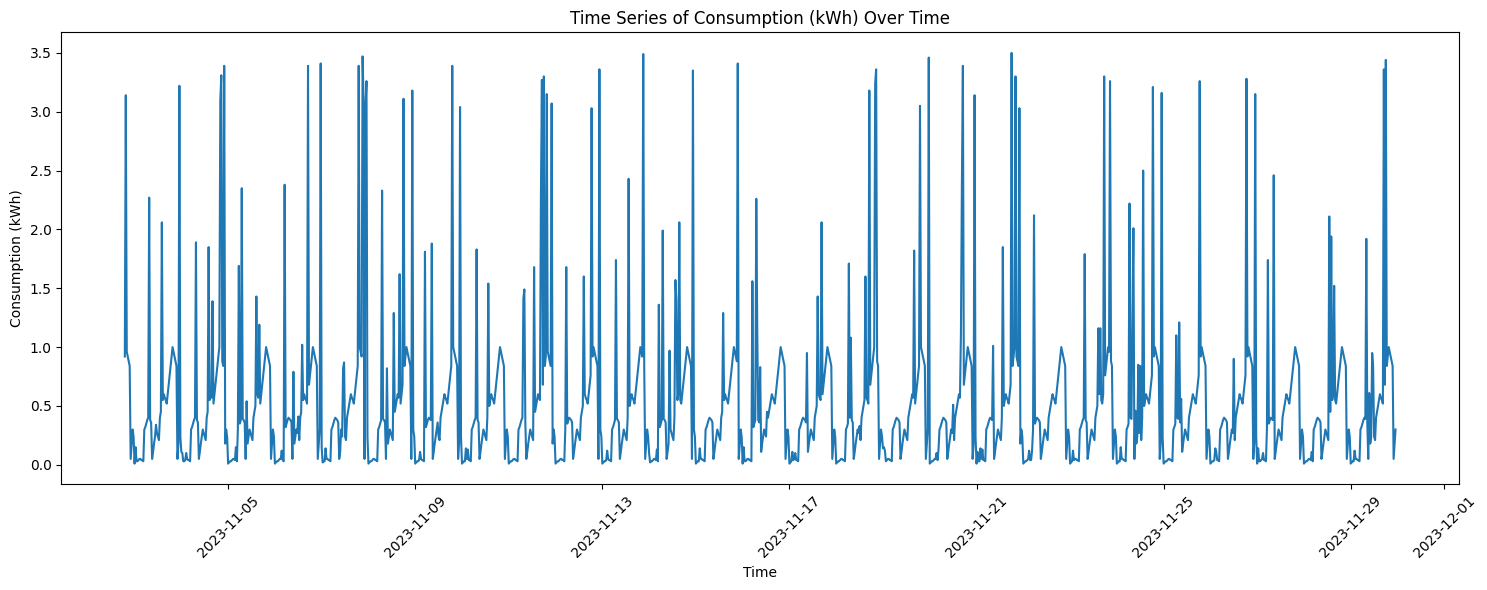

In [45]:
plt.figure(figsize=(15, 6))
sns.lineplot(x='datetime', y='Consumption (kWh)', data=df)
plt.title('Time Series of Consumption (kWh) Over Time')
plt.xlabel('Time')
plt.ylabel('Consumption (kWh)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

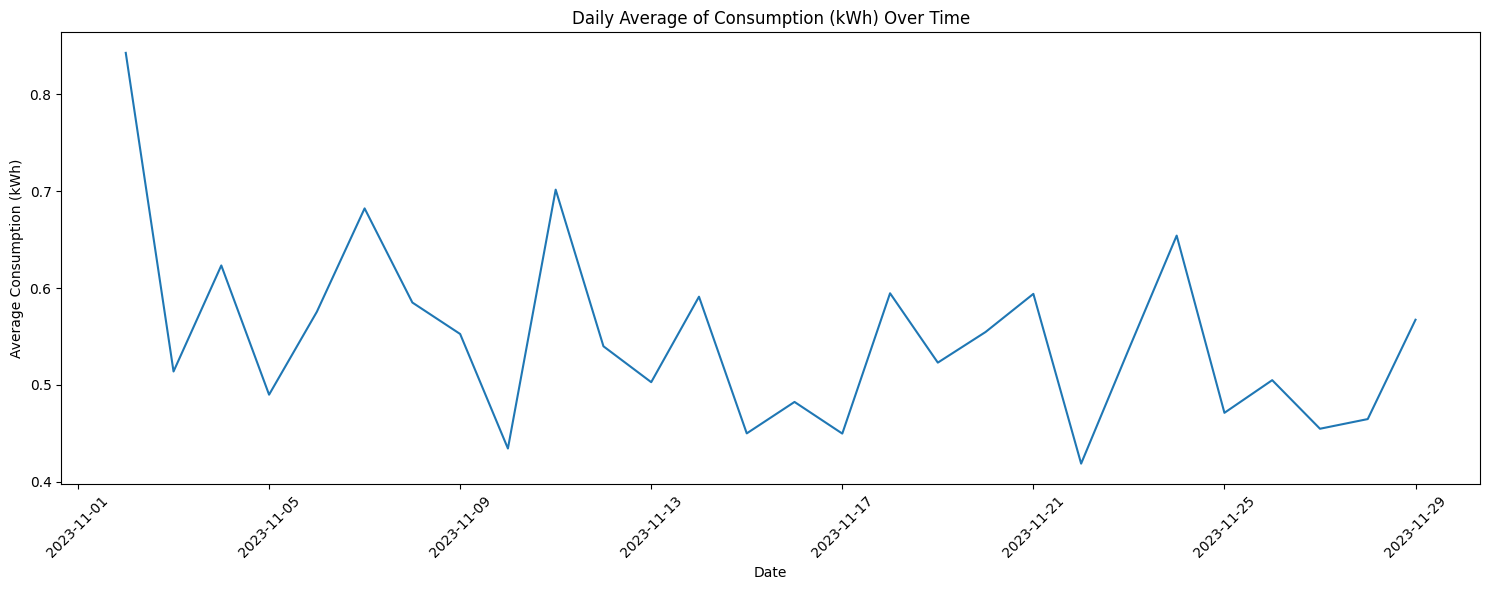

In [49]:
df['date'] = df['datetime'].dt.date
daily_avg_consumption = df.groupby('date')['Consumption (kWh)'].mean().reset_index()

plt.figure(figsize=(15, 6))
sns.lineplot(x='date', y='Consumption (kWh)', data=daily_avg_consumption)
plt.title('Daily Average of Consumption (kWh) Over Time')
plt.xlabel('Date')
plt.ylabel('Average Consumption (kWh)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

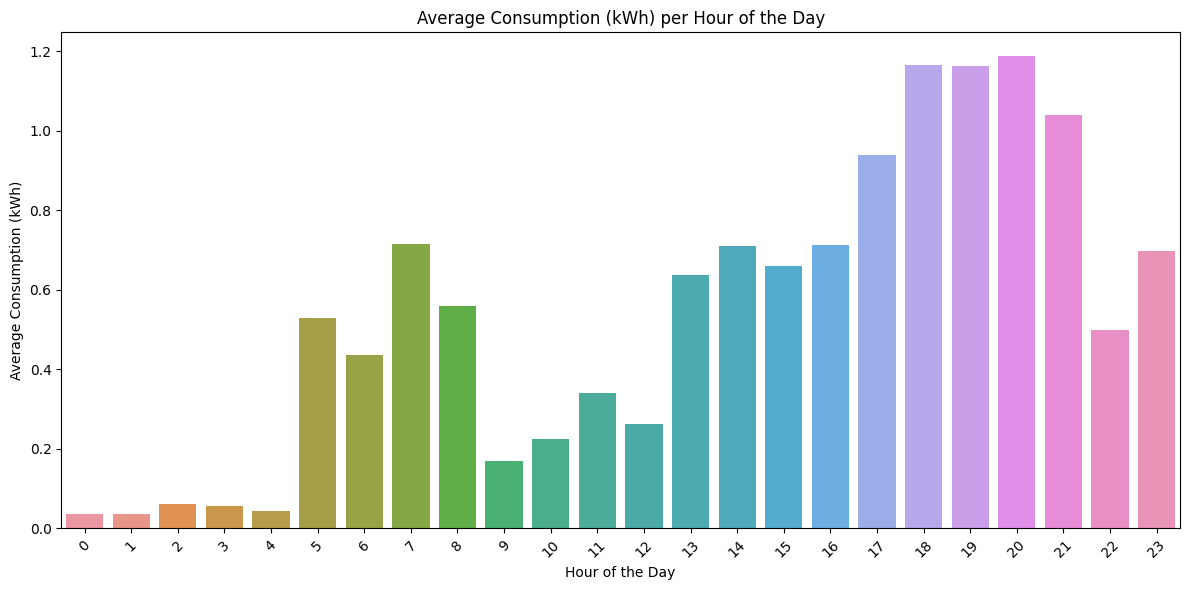

In [50]:
# Grouping the data by hour and calculating the average consumption for each hour of the day
hourly_avg_consumption = df.groupby('hour')['Consumption (kWh)'].mean().reset_index()

# Plotting the average consumption for each hour of the day
plt.figure(figsize=(12, 6))
sns.barplot(x='hour', y='Consumption (kWh)', data=hourly_avg_consumption)
plt.title('Average Consumption (kWh) per Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Consumption (kWh)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


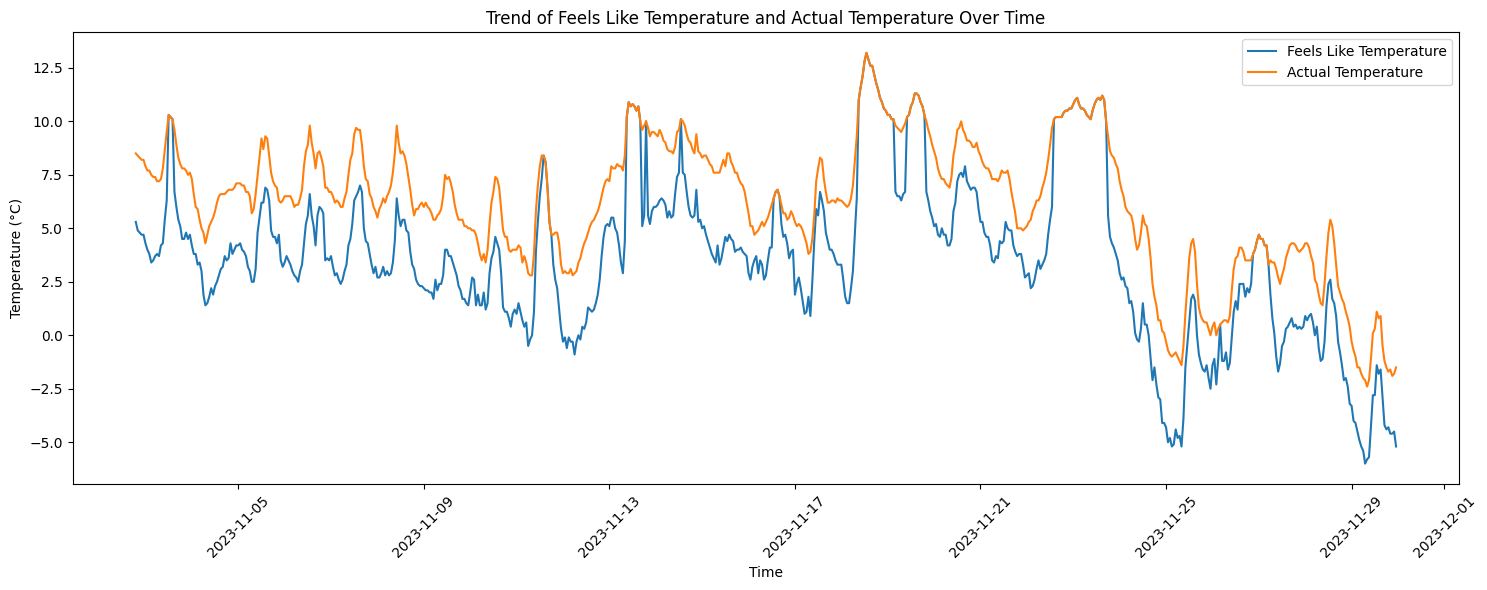

In [51]:
# Plotting the trend of 'feelslike' and 'temp' over time
plt.figure(figsize=(15, 6))
sns.lineplot(x='datetime', y='feelslike', data=df, label='Feels Like Temperature')
sns.lineplot(x='datetime', y='temp', data=df, label='Actual Temperature')
plt.title('Trend of Feels Like Temperature and Actual Temperature Over Time')
plt.xlabel('Time')
plt.ylabel('Temperature (°C)')
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


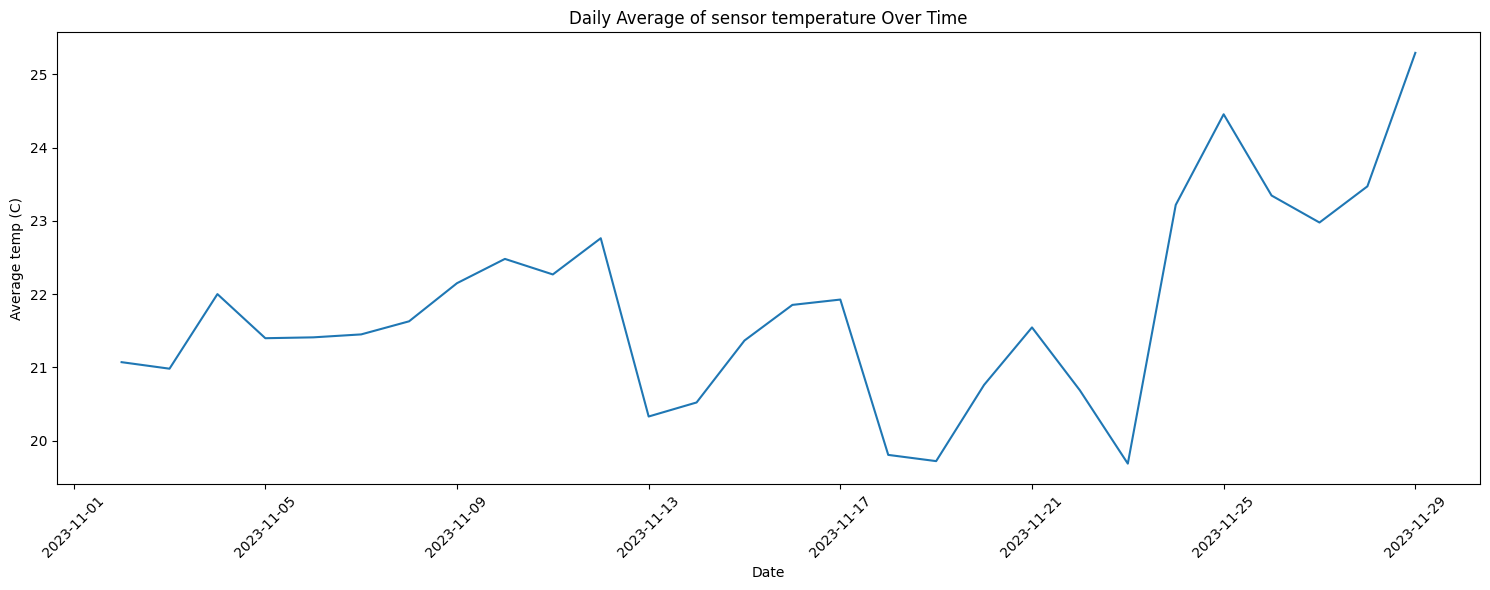

In [62]:
daily_avg_sensor_temp = df.groupby('date')['sensor_temp'].mean().reset_index()

plt.figure(figsize=(15, 6))
sns.lineplot(x='date', y='sensor_temp', data=daily_avg_sensor_temp)
plt.title('Daily Average of sensor temperature Over Time')
plt.xlabel('Date')
plt.ylabel('Average temp (C)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

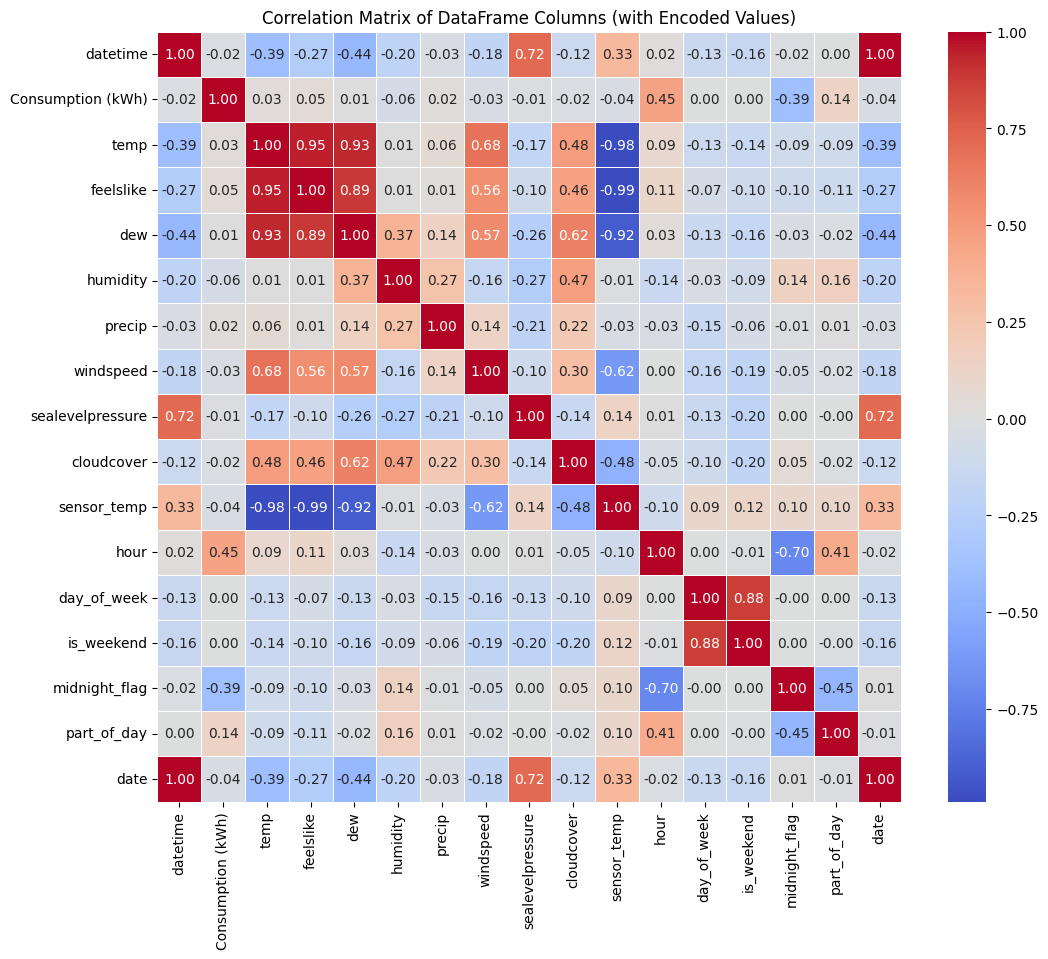

In [58]:
df_encoded = df.copy()

object_cols = df_encoded.select_dtypes(include=['object','category']).columns

label_encoder = LabelEncoder()
for col in object_cols:
    df_encoded[col] = label_encoder.fit_transform(df_encoded[col])

correlation_matrix_encoded = df_encoded.corr()

# Plotting the correlation matrix
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_encoded, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of DataFrame Columns (with Encoded Values)')
plt.show()

In [63]:
best_features = ['datetime','hour', 'midnight_flag', 'part_of_day', 'humidity', 'feelslike','temp','sensor_temp']

df_best_features = df_encoded[best_features + ['Consumption (kWh)']]

df_best_features


,datetime,hour,midnight_flag,part_of_day,humidity,feelslike,temp,sensor_temp,Consumption (kWh)
86,2023-11-02 19:00:00,19,False,2,97.650,5.30,8.50,20.913295,0.92
87,2023-11-02 19:30:00,19,False,2,96.495,5.10,8.45,20.971098,3.14
88,2023-11-02 20:00:00,20,False,2,95.340,4.90,8.40,21.028902,0.96
89,2023-11-02 20:30:00,20,False,2,94.745,4.85,8.35,21.052023,0.92
90,2023-11-02 21:00:00,21,False,6,94.150,4.80,8.30,21.075145,0.88
...,...,...,...,...,...,...,...,...,...
1386,2023-11-29 21:00:00,21,False,6,90.380,-4.60,-1.90,25.606936,0.88
1387,2023-11-29 21:30:00,21,False,6,89.740,-4.55,-1.85,25.583815,0.84
1388,2023-11-29 22:00:00,22,False,6,89.100,-4.50,-1.80,25.560694,0.05
1389,2023-11-29 22:30:00,22,False,6,90.105,-4.85,-1.65,25.606936,0.18


In [64]:
df_best_features.to_csv('bestFeatures.csv', index=False)